# Proyek Klasifikasi Gambar: Kucing dan Anjing
- **Nama:** M Fauzan Fachruzi Rauf
- **Email:** fauzan01rauf@gmail.com
- **ID Dicoding:** mfauzanfr01

## Import Semua Packages/Library yang Digunakan

In [1]:
# Install tensorflowjs untuk menyimpan model sebagai tfjs
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 1.7 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [2]:
# Import library utama untuk deep learning dan preprocessing data
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Import library untuk analisis data dan visualisasi
import pandas as pd
import matplotlib.pyplot as plt

# Import library untuk manipulasi file dan direktori
import os
import zipfile

# Import library untuk membagi dataset menjadi data latih dan data uji
from sklearn.model_selection import train_test_split

# Import library untuk mengunggah file di Google Colab
from google.colab import files

# Import modul untuk memproses gambar secara manual
from tensorflow.keras.preprocessing import image
import numpy as np
import cv2
import io
from google.colab import files  # (import ini duplikat, tapi dibiarkan karena tidak mengubah fungsionalitas)

# Catatan:
# - TensorFlow digunakan untuk membuat model CNN
# - ImageDataGenerator dipakai untuk augmentasi data gambar
# - cv2 (OpenCV) berguna untuk operasi pengolahan citra lanjutan jika diperlukan
# - files dari Colab membantu dalam upload atau download file dari lokal ke Colab
# - Semua import ini umum digunakan dalam pipeline deep learning berbasis gambar

## Data Preparation

### Data Loading

In [3]:
# ===============================
# Upload file kaggle.json untuk autentikasi ke Kaggle
# ===============================
files.upload()

# Membuat direktori tersembunyi .kaggle di home
!mkdir -p ~/.kaggle

# Memindahkan kaggle.json ke direktori .kaggle
!mv kaggle.json ~/.kaggle/

# Mengatur permission file agar hanya bisa diakses oleh user
!chmod 600 ~/.kaggle/kaggle.json

# ===============================
# Instalasi library kaggle untuk mengakses dataset
# ===============================
!pip install -q kaggle

# ===============================
# Download dataset dari Kaggle
# ===============================
!kaggle datasets download -d ashfakyeafi/cat-dog-images-for-classification

Saving archive.zip to archive.zip
mv: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 10, in <module>
    sys.exit(main())
             ^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/kaggle/cli.py", line 68, in main
    out = args.func(**command_args)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/kaggle/api/kaggle_api_extended.py", line 1734, in dataset_download_cli
    with self.build_kaggle_client() as kaggle:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/kaggle/api/kaggle_api_extended.py", line 688, in build_kaggle_client
    username=self.config_values['username'],
             ~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^
KeyError: 'username'


In [4]:
# ===============================
# Ekstrak file ZIP dataset ke dalam folder data
# ===============================
zip_file_path = "archive.zip"
extraction_path = "data"

try:
    # Membuka file zip dan mengekstrak semua isinya ke folder tujuan
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extraction_path)
    print(f"File {zip_file_path} berhasil diekstrak ke folder {extraction_path}.")
except Exception as e:
    # Menangkap error jika terjadi kesalahan saat ekstraksi
    print(f"Terjadi kesalahan saat mengekstrak file: {e}")

# ===============================
# Load dataset ke dalam DataFrame
# ===============================
csv_file_path = os.path.join(extraction_path, "cat_dog.csv")
df = pd.read_csv(csv_file_path)

# ===============================
# Perbaikan path gambar di kolom "image"
# ===============================
df['image'] = df['image'].apply(lambda x: os.path.join(extraction_path, "cat_dog", x))

# ===============================
# Pastikan kolom "labels" bertipe string
# ===============================
df['labels'] = df['labels'].astype(str)

# ===============================
# Filter data: hapus entri yang file gambarnya tidak ada
# ===============================
df = df[df['image'].apply(os.path.exists)]

# ===============================
# Tampilkan statistik sederhana tentang dataset
# ===============================
image_count = len(df)
label_counts = df['labels'].value_counts().to_dict()
print(f"Dataset: {image_count} images ({label_counts})")

File archive.zip berhasil diekstrak ke folder data.
Dataset: 25000 images ({'1': 12500, '0': 12500})


### Data Preprocessing

#### Split Dataset

In [5]:
# ===============================
# Memisahkan dataset menjadi train_df, val_df, dan test_df
# ===============================
# - 60% data untuk training
# - 20% data untuk validation
# - 20% data untuk testing
train_df, temp_df = train_test_split(df, test_size=0.4, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# ===============================
# Definisi fungsi untuk membuat ImageDataGenerator
# ===============================
def create_generator(df, augment=False):
    # Jika augment=True, tambahkan augmentasi sederhana seperti rotasi dan flip
    return ImageDataGenerator(
        rescale=1./255,
        **({'rotation_range': 20, 'horizontal_flip': True} if augment else {})
    ).flow_from_dataframe(
        dataframe=df,
        x_col='image',        # Kolom yang berisi path gambar
        y_col='labels',       # Kolom label
        target_size=(150, 150), # Ukuran gambar di-resize ke 150x150
        batch_size=32,          # Ukuran batch saat training
        class_mode='binary',    # Tugas klasifikasi biner (kucing atau anjing)
        shuffle=augment         # Data diacak hanya untuk training
    )

# ===============================
# Membuat generator untuk data training, validasi, dan testing
# ===============================
train_gen = create_generator(train_df, augment=True)  # Dengan augmentasi
val_gen = create_generator(val_df)                   # Tanpa augmentasi
test_gen = create_generator(test_df)                  # Tanpa augmentasi

Found 15000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


## Modelling

In [6]:
# ===============================
# Membuat arsitektur model CNN
# ===============================
model = models.Sequential([
    # Layer konvolusi pertama dengan 32 filter 3x3 dan aktivasi ReLU
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    # MaxPooling untuk mengurangi dimensi feature map
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Layer konvolusi kedua dengan 64 filter
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Layer konvolusi ketiga dengan 128 filter
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),

    # Flatten untuk mengubah feature map menjadi vektor 1D
    layers.Flatten(),

    # Dense layer dengan 128 neuron dan aktivasi ReLU
    layers.Dense(128, activation='relu'),

    # Dropout untuk mencegah overfitting (rate dropout 50%)
    layers.Dropout(0.5),

    # Output layer dengan 1 neuron dan aktivasi sigmoid (karena klasifikasi biner)
    layers.Dense(1, activation='sigmoid')
])

# ===============================
# Mengkompilasi model
# ===============================
model.compile(
    optimizer='adam',                # Optimizer Adam untuk update bobot
    loss='binary_crossentropy',       # Loss function untuk klasifikasi biner
    metrics=['accuracy']              # Evaluasi model dengan metrik akurasi
)

# ===============================
# Melatih model
# ===============================
history = model.fit(
    train_gen,                        # Menggunakan data dari train_gen
    epochs=30,                        # Melatih selama 30 epoch
    validation_data=val_gen           # Menggunakan val_gen untuk validasi setiap epoch
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 769s 2s/step - accuracy: 0.5471 - loss: 0.7114 - val_accuracy: 0.6796 - val_loss: 0.6032
Epoch 2/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 774s 2s/step - accuracy: 0.6872 - loss: 0.5941 - val_accuracy: 0.7470 - val_loss: 0.5062
Epoch 3/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 747s 2s/step - accuracy: 0.7382 - loss: 0.5205 - val_accuracy: 0.7960 - val_loss: 0.4428
Epoch 4/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 734s 2s/step - accuracy: 0.7745 - loss: 0.4740 - val_accuracy: 0.8172 - val_loss: 0.4036
Epoch 5/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 735s 2s/step - accuracy: 0.8016 - loss: 0.4405 - val_accuracy: 0.8146 - val_loss: 0.4056
Epoch 6/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 730s 2s/step - accuracy: 0.8185 - loss: 0.4056 - val_accuracy: 0.8386 - val_loss: 0.3580
Epoch 7/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 731s 2s/step - accuracy: 0.8282 - loss: 0.3823 - val_accuracy: 0.8400 - val_loss: 0.3543
Epoch 8/30
469/469 ━━━━━━━━━━━━━━━━━━━━ 735s 2s/step - accuracy: 0.8411 - loss: 0.3575 - val_accu

## Evaluasi dan Visualisasi

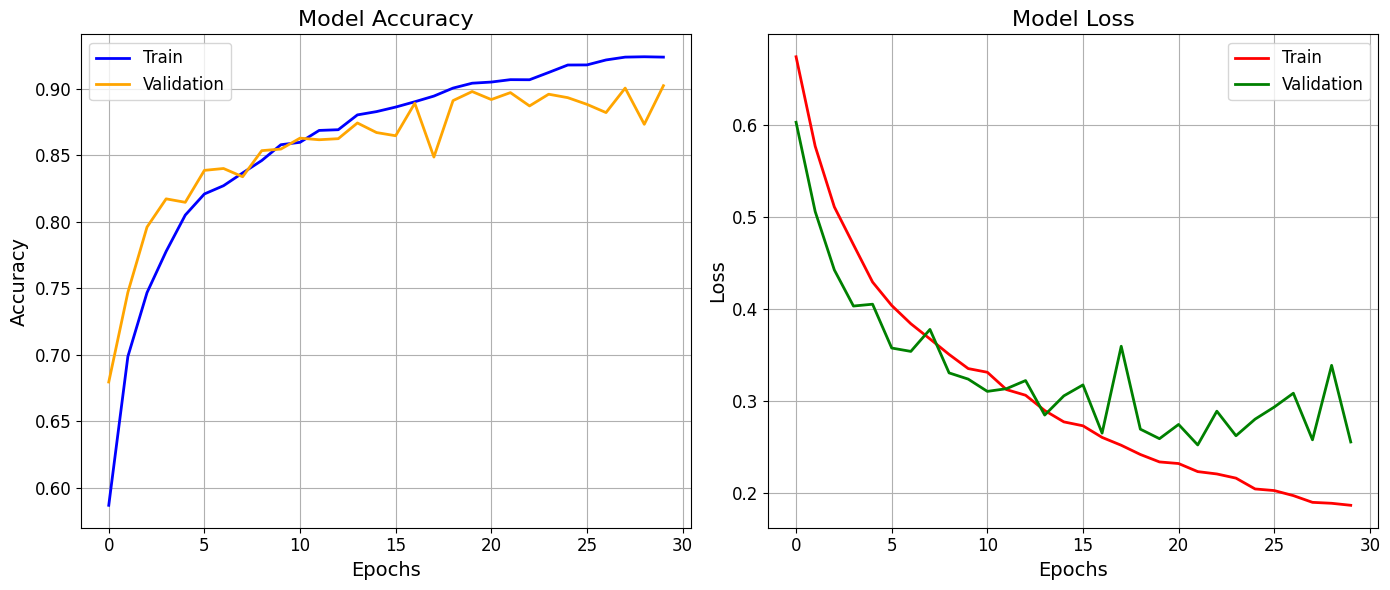

In [7]:
# ===============================
# Visualisasi Akurasi dan Loss Selama Training
# ===============================

# Mengatur ukuran figure secara keseluruhan
plt.figure(figsize=(14, 6))

# ===============================
# Plot Akurasi
# ===============================
plt.subplot(1, 2, 1)  # Membuat subplot pertama (1 baris, 2 kolom, posisi 1)
plt.plot(history.history['accuracy'], label='Train', color='blue', linewidth=2)  # Akurasi data training
plt.plot(history.history['val_accuracy'], label='Validation', color='orange', linewidth=2)  # Akurasi data validasi
plt.title('Model Accuracy', fontsize=16)  # Judul plot
plt.xlabel('Epochs', fontsize=14)  # Label sumbu x
plt.ylabel('Accuracy', fontsize=14)  # Label sumbu y
plt.xticks(fontsize=12)  # Ukuran font sumbu x
plt.yticks(fontsize=12)  # Ukuran font sumbu y
plt.grid(True)  # Menampilkan grid
plt.legend(fontsize=12)  # Menampilkan legenda
plt.tight_layout()  # Mengatur tata letak agar tidak tumpang tindih

# ===============================
# Plot Loss
# ===============================
plt.subplot(1, 2, 2)  # Membuat subplot kedua (1 baris, 2 kolom, posisi 2)
plt.plot(history.history['loss'], label='Train', color='red', linewidth=2)  # Loss data training
plt.plot(history.history['val_loss'], label='Validation', color='green', linewidth=2)  # Loss data validasi
plt.title('Model Loss', fontsize=16)  # Judul plot
plt.xlabel('Epochs', fontsize=14)  # Label sumbu x
plt.ylabel('Loss', fontsize=14)  # Label sumbu y
plt.xticks(fontsize=12)  # Ukuran font sumbu x
plt.yticks(fontsize=12)  # Ukuran font sumbu y
plt.grid(True)  # Menampilkan grid
plt.legend(fontsize=12)  # Menampilkan legenda
plt.tight_layout()  # Mengatur tata letak agar tidak tumpang tindih

# ===============================
# Menampilkan plot
# ===============================
plt.show()

In [8]:
# ===============================
# Evaluasi Model pada Data Training dan Testing
# ===============================

# ===============================
# Evaluasi pada Data Latih
# ===============================
train_loss, train_acc = model.evaluate(train_gen)  # Menghitung loss dan akurasi pada data training
print(f"Akurasi Data Latih: {train_acc:.2%}")  # Menampilkan akurasi data latih dalam persentase

# ===============================
# Evaluasi pada Data Uji
# ===============================
test_loss, test_acc = model.evaluate(test_gen)  # Menghitung loss dan akurasi pada data testing
print(f"Akurasi Data Uji: {test_acc:.2%}")  # Menampilkan akurasi data uji dalam persentase

469/469 ━━━━━━━━━━━━━━━━━━━━ 254s 540ms/step - accuracy: 0.9433 - loss: 0.1481
Akurasi Data Latih: 94.41%
157/157 ━━━━━━━━━━━━━━━━━━━━ 63s 402ms/step - accuracy: 0.8995 - loss: 0.2737
Akurasi Data Uji: 89.96%


## Konversi Model

In [9]:
# ===============================
# Menyimpan Model ke Format SavedModel
# ===============================
tf.saved_model.save(model, 'saved_model')  # Menyimpan model dalam format TensorFlow SavedModel

# ===============================
# Mengonversi dan Menyimpan Model ke Format TFLite
# ===============================
converter = tf.lite.TFLiteConverter.from_keras_model(model)  # Membuat konverter dari model Keras

# Membuat folder 'tflite' jika belum ada
os.makedirs('tflite', exist_ok=True)

# Menyimpan model dalam format .tflite
with open('tflite/model.tflite', 'wb') as f:
    f.write(converter.convert())

# ===============================
# Membuat File label.txt untuk Kebutuhan TFLite
# ===============================
with open('tflite/label.txt', 'w') as f:
    f.write("Cat\nDog\n")  # Menuliskan label kategori ke dalam file teks

Saved artifact at '/tmp/tmpign48srs'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  134253080306576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134253080307344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134253080310224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134253080308496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134253080309648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134253080310992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134253080306768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134253080311376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134253080311760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134253080313296: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [10]:
# ===============================
# Mengonversi Model ke Format TensorFlow.js (TFJS)
# ===============================
# Menggunakan tensorflowjs_converter untuk mengubah SavedModel ke format yang bisa dipakai di browser
!tensorflowjs_converter --input_format=tf_saved_model saved_model tfjs_model

2025-04-29 01:13:20.425953: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745889200.470149  108384 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745889200.483736  108384 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
2025-04-29 01:13:34.226847: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
I0000 00:00:1745889215.006625  108384 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
I0000 00:00

## Inference (Optional)

Saving images.jpeg to images.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step


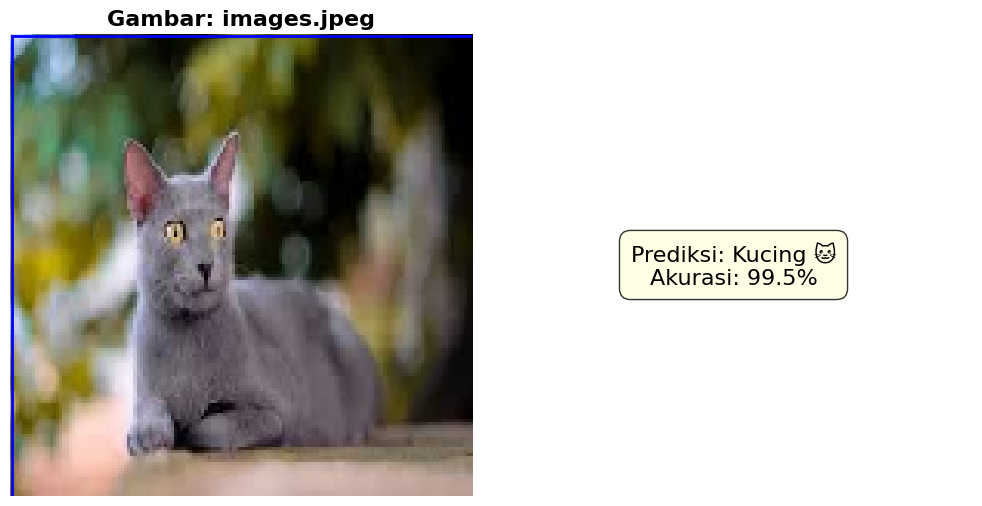


Hasil: Kucing 🐱 (99.5% akurat)


In [11]:
# ===============================
# Upload dan Prediksi Gambar
# ===============================

# Upload gambar dari lokal
uploaded = files.upload()

# Melakukan prediksi untuk setiap gambar yang diupload
for filename in uploaded.keys():
    # Membaca gambar dan mengubah ukurannya ke (150, 150)
    img_bytes = uploaded[filename]
    img = image.load_img(io.BytesIO(img_bytes), target_size=(150, 150))

    # Konversi gambar menjadi array dan normalisasi
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Prediksi menggunakan model yang telah dilatih
    confidence = model.predict(img_array)[0][0]
    predicted_class = "Anjing 🐶" if confidence > 0.5 else "Kucing 🐱"
    confidence_pct = max(confidence, 1 - confidence) * 100

    # Visualisasi gambar dan hasil prediksi
    plt.figure(figsize=(10, 5))

    # Menampilkan gambar
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title(f"Gambar: {filename}", fontsize=16, fontweight='bold')
    plt.axis('off')
    plt.gca().add_patch(plt.Rectangle((0, 0), 150, 150, linewidth=2, edgecolor='blue', facecolor='none'))

    # Menampilkan hasil prediksi
    plt.subplot(1, 2, 2)
    plt.text(0.5, 0.5,
             f"Prediksi: {predicted_class}\nAkurasi: {confidence_pct:.1f}%",
             fontsize=16,
             ha='center', va='center',
             bbox=dict(facecolor='lightyellow', alpha=0.8, edgecolor='black', boxstyle='round,pad=0.5'))
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    # Cetak hasil prediksi di console
    print(f"\nHasil: {predicted_class} ({confidence_pct:.1f}% akurat)")

In [12]:
# ===============================
# Membuat File requirements.txt
# ===============================

# Menyimpan daftar semua library yang digunakan ke file requirements.txt
!pip freeze > requirements.txt

In [13]:
# ===============================
# Mengompres folder tfjs_model ke dalam file tfjs_model.zip
# ===============================
!zip -r tfjs_model.zip tfjs_model

  adding: tfjs_model/ (stored 0%)
  adding: tfjs_model/group1-shard2of5.bin (deflated 6%)
  adding: tfjs_model/group1-shard1of5.bin (deflated 6%)
  adding: tfjs_model/model.json (deflated 88%)
  adding: tfjs_model/group1-shard3of5.bin (deflated 6%)
  adding: tfjs_model/group1-shard4of5.bin (deflated 6%)
  adding: tfjs_model/group1-shard5of5.bin (deflated 6%)
